# 1. Train on Actual Tasks
I decided to use the MNIST dataset to train a DNN.

In [1]:
import numpy as np
from pylab import imshow
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
print(torch.__version__)

1.13.1


In [3]:
# Fetch and load mnist data
def fetch(url):
    import requests, gzip, os, hashlib
    filepath = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(filepath):
        with open(filepath, "rb") as f:
            data = f.read()
    else:
        with open(filepath, "wb") as f:
            data = requests.get(url).content
            f.write(data)
    return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

train_image_data = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")
train_labels_data = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")
test_image_data = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")
test_labels_data = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")



In [4]:
### Clean data
# Remove non image/non-label data (i.e. magic number, num_images/num_items,
# num_rows, num_columns, etc)
relevant_train_img_d = train_image_data[0x10:]
Y_train = train_labels_data[8:]
relevant_test_img_d = test_image_data[0x10:]
Y_test = test_labels_data[8:]

# Each image is made of 28 rows and 28 columns (a matrix of 28x28) with a 
# value between 0 and 255 that represents a black and white color scale
# (0 = black and 255 = white)
# Reshape data to create a matrix of 28 rows and 28 columns
# -1 means that we have an unknown dimension and we want numpyt to figure it out
X_train = relevant_train_img_d.reshape((-1,28,28))
X_test = relevant_test_img_d.reshape((-1,28,28))

print("X_train shape:", X_train.shape) # X_train -> 60,000 matrices of 28x28
print("Y_train shape", Y_train.shape) # Y_train -> 60,000 labels 

X_train shape: (60000, 28, 28)
Y_train shape (60000,)


(<matplotlib.image.AxesImage at 0x14f13faf5e20>, 5)

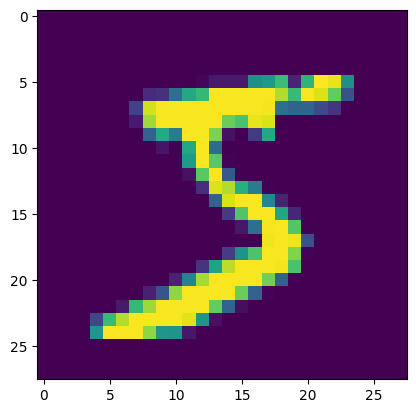

In [5]:
# We can use matplotlib.pyplot.imshow to display image
imshow(X_train[0]), Y_train[0]

## Model:
* The model uses 2 layers and 4 parameters:
  * An input layer of size 28 * 28 = 784
  * One hidden layer of dimension (784, 128)
  * One output layer with dimension (128, 10)

* The output is a layer of 10 because each index represents the possible labels that the image represents

* The model uses a ReLU activation function

* CrossEntropyLoss() is very useful in training multiclass classification problems. 

In [25]:
# model
import torch
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(784, 128) # 28*28 = 728
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x

model = Model()
#print(model, len(list(model.parameters())))

In [23]:
# Training loop
epochs = 2000

#BATCH_SIZE = 32
BATCH_SIZE = 128
LEARNING_RATE = 0.001

loss_function = nn.CrossEntropyLoss()

#optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) #Adam
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE) #SGD


epoch_count = []
loss_values = []
accuracy_values = []

weights = []
for epoch in range(epochs):
    sample = np.random.randint(0, X_train.shape[0], size=(BATCH_SIZE))
    X = X_train[sample]
    X = torch.tensor(X.reshape((-1, 28*28))).float()
    Y = torch.tensor(Y_train[sample])

    optimizer.zero_grad()

    y_prediction = model(X)

    # Calculate accuracy
    max_pred = torch.argmax(y_prediction, dim=1) # max predicted value
    accuracy = (max_pred == Y).float().mean()# counts the number of correct predictions in model (num of True)
    accuracy_values.append(accuracy)

    loss = loss_function(y_prediction, Y)

    loss.backward()

    optimizer.step()
    epoch_count.append(epoch)
    loss_values.append(loss.item())

    if (epoch % 100 == 0):
        print(f"Epoch: {epoch} ,Loss: {loss.item()}, | Accuracy: {accuracy.item()}")

    # Gets weigths every 3 epochs:
    if (epoch % 30 == 0):
        weight = model.linear1.weight
        weights.append(weight)

   



Epoch: 0 ,Loss: 0.11376527696847916, | Accuracy: 0.9609375
Epoch: 100 ,Loss: 0.20939789712429047, | Accuracy: 0.9453125
Epoch: 200 ,Loss: 0.1182633712887764, | Accuracy: 0.984375
Epoch: 300 ,Loss: 0.25560230016708374, | Accuracy: 0.921875
Epoch: 400 ,Loss: 0.1699909120798111, | Accuracy: 0.9609375
Epoch: 500 ,Loss: 0.19332920014858246, | Accuracy: 0.9375
Epoch: 600 ,Loss: 0.08403225988149643, | Accuracy: 0.9765625
Epoch: 700 ,Loss: 0.18508443236351013, | Accuracy: 0.9453125
Epoch: 800 ,Loss: 0.14199037849903107, | Accuracy: 0.953125
Epoch: 900 ,Loss: 0.10366182774305344, | Accuracy: 0.96875
Epoch: 1000 ,Loss: 0.2012079656124115, | Accuracy: 0.921875
Epoch: 1100 ,Loss: 0.29255637526512146, | Accuracy: 0.921875
Epoch: 1200 ,Loss: 0.1250510811805725, | Accuracy: 0.953125
Epoch: 1300 ,Loss: 0.06700797379016876, | Accuracy: 0.984375
Epoch: 1400 ,Loss: 0.07628638297319412, | Accuracy: 0.984375
Epoch: 1500 ,Loss: 0.09831498563289642, | Accuracy: 0.96875
Epoch: 1600 ,Loss: 0.18233215808868408,

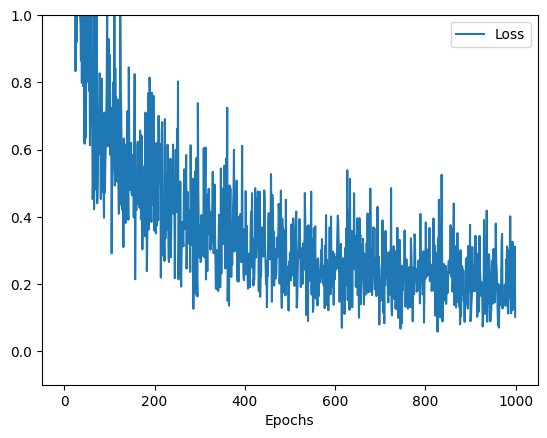

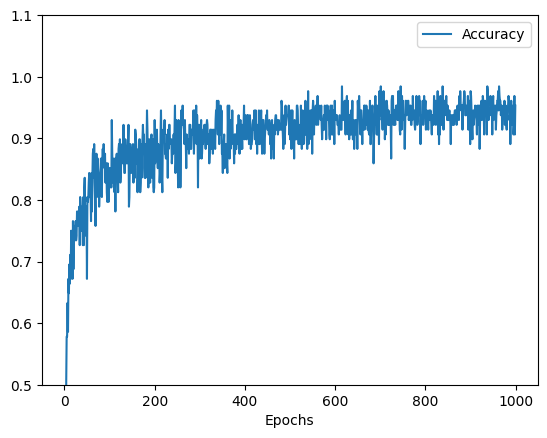

In [19]:
plt.plot(epoch_count, loss_values, label="Loss")
plt.ylim(-0.1, 1)
plt.legend()
plt.xlabel("Epochs")
plt.show()

plt.plot(epoch_count, accuracy_values, label="Accuracy")
plt.ylim(0.5, 1.1)
plt.legend()
plt.xlabel("Epochs")
plt.show()

In [20]:
# Evaluation
X_test_tensor = torch.tensor(X_test.reshape((-1, 28*28))).float()
Y_test_preds = model(X_test_tensor)
Y_test_max = torch.argmax(Y_test_preds, dim=1).numpy()
#print("1",Y_test_preds, len(Y_test_preds))
#print("2", Y_test_max)
#Y_test_predictions = torch.argmax(test)
print((Y_test == Y_test_max).mean())


0.9326


# Model 2
For the second model I implement a Neural Network with a sequential model with:
* An input layer of size 28 * 28 = 784
* Each image is made of 28 rows and 28 columns 
* Two hidden layers 
    ** (784, 128) with ReLU activation function
    ** (128, 64) with ReLU activation function
* One output layer with dimension (64, 10)

* Uses softmax activation function (softmax are used with classification problems)

In [21]:
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.regressor = nn.Sequential(nn.Linear(784, 128),
                                   nn.ReLU(inplace=True),
                                   nn.Linear(128, 64),
                                   nn.ReLU(inplace=True),
                                   #nn.Linear(1024, 1024),
                                   nn.Linear(64, 10),
                                   nn.LogSoftmax(dim=1))
        

    def forward(self, x):
        output = self.regressor(x)
        return output


In [24]:
model2 = Model2()

loss_function = nn.NLLLoss()

# Training loop
epochs = 2000

LEARNING_RATE = 0.003
MOMENTUM = 0.9
#BATCH_SIZE = 128
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

epoch_count_m2 = []
loss_values_m2 = []
accuracy_values_m2 = []

for epoch in range(epochs):
    # Use whole train set
    #sample = np.random.randint(0, X_train.shape[0], size=(BATCH_SIZE))
    sample = np.random.randint(0, X_train.shape[0], size = len(X_train))
    # sample from whole array
    X = X_train[sample]
    X = torch.tensor(X.reshape((-1, 28*28))).float()
    Y = torch.tensor(Y_train[sample])

    optimizer.zero_grad()

    y_prediction = model2(X)

    # Calculate accuracy
    max_pred = torch.argmax(y_prediction, dim=1) # max predicted value
    accuracy = (max_pred == Y).float().mean()# counts the number of correct predictions in model (num of True)
    accuracy_values_m2.append(accuracy)
    
    loss = loss_function(y_prediction, Y)

    loss.backward()

    optimizer.step()
    epoch_count_m2.append(epoch)
    loss_values_m2.append(loss.item())

    if (epoch % 500 == 0):
      print(f"Epoch: {epoch} ,Loss: {loss.item()}, | Accuracy: {accuracy.item()}")


Epoch: 0 ,Loss: 12.115028381347656, | Accuracy: 0.08191666752099991
Epoch: 500 ,Loss: 12.082841873168945, | Accuracy: 0.0843999981880188
Epoch: 1000 ,Loss: 12.105405807495117, | Accuracy: 0.08145000040531158
Epoch: 1500 ,Loss: 12.041407585144043, | Accuracy: 0.08348333090543747


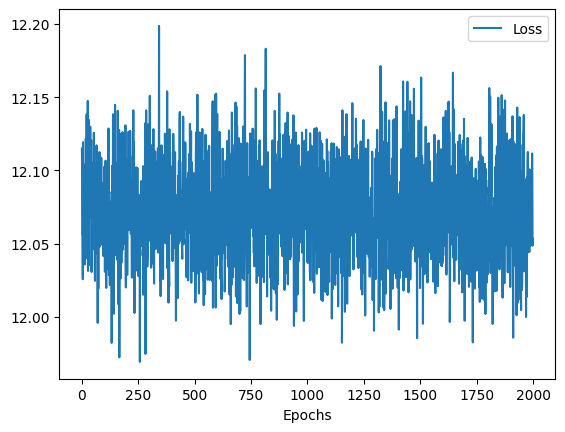

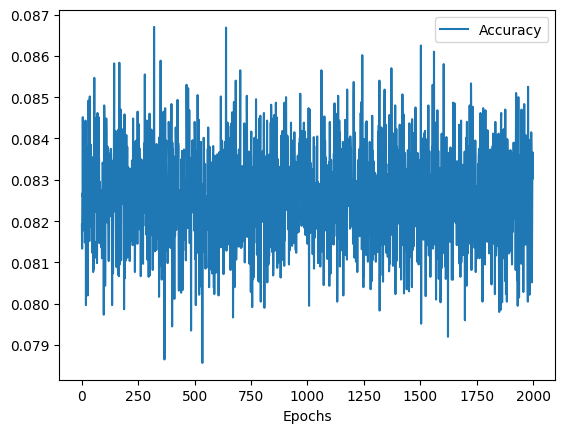

In [26]:
plt.plot(epoch_count_m2, loss_values_m2, label="Loss")
#plt.ylim(-0.1, 2.5)
plt.legend()
plt.xlabel("Epochs")
plt.show()

plt.plot(epoch_count_m2, accuracy_values_m2, label="Accuracy")
#plt.ylim(-0.1, 1.1)
plt.legend()
plt.xlabel("Epochs")
plt.show()

len(epoch_count) 2000
len(epoch_count_m2) 2000


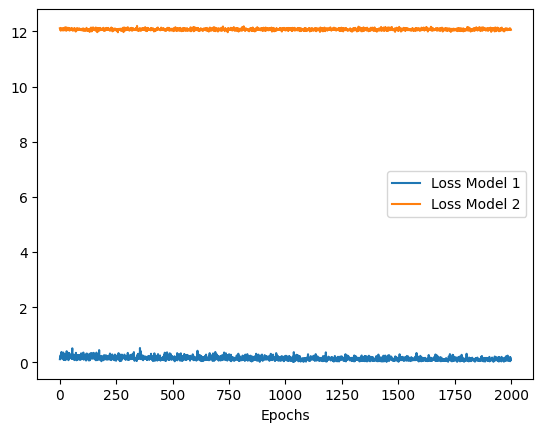

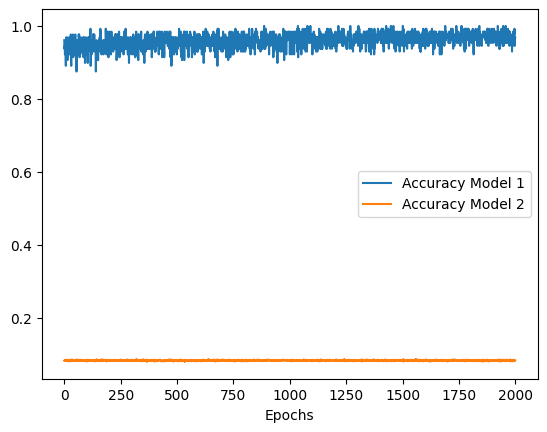

In [27]:
print("len(epoch_count)", len(epoch_count))
print("len(epoch_count_m2)", len(epoch_count_m2))
plt.plot(epoch_count_m2, loss_values, label="Loss Model 1")
plt.plot(epoch_count_m2, loss_values_m2, label="Loss Model 2")
#plt.ylim(-0.1, 2.5)
plt.legend()
plt.xlabel("Epochs")
plt.show()

plt.plot(epoch_count_m2, accuracy_values, label="Accuracy Model 1")
plt.plot(epoch_count_m2, accuracy_values_m2, label="Accuracy Model 2")
#plt.ylim(-0.1, 1.1)
plt.legend()
plt.xlabel("Epochs")
plt.show()

# Visualizing optimization process
Collect weights every n epochs, ans train 8 times (TA said we could change the ratio at which we collect weights)

In [28]:
import pandas as pd
from sklearn.decomposition import PCA

# Training loop
epochs = 1000

#BATCH_SIZE = 32
BATCH_SIZE = 128
LEARNING_RATE = 0.001

loss_function = nn.CrossEntropyLoss()

#optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) #Adam
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE) #SGD

colors = ["b", "g", "r", "c", "m","y", "b"]
x_s = []
y_s = []
for i in range(7):
    weights = []
    for epoch in range(epochs):
        sample = np.random.randint(0, X_train.shape[0], size=(BATCH_SIZE))
        # sample from whole array
        X = X_train[sample]
        X = torch.tensor(X.reshape((-1, 28*28))).float()
        Y = torch.tensor(Y_train[sample])

        optimizer.zero_grad()

        y_prediction = model(X)

        loss = loss_function(y_prediction, Y)

        loss.backward()

        optimizer.step()

        if (epoch % 500 == 0):
          print(f"Epoch: {epoch} ,Loss: {loss.item()}, | Accuracy: {accuracy.item()}")

        # Gets weigths every 3 epochs:
        if (epoch % 3 == 0):
            weight = model.linear2.weight
            weights.append(weight)
  
    all_weights = torch.cat(weights, 1)  
    df = pd.DataFrame(all_weights.detach().numpy())
    df_temp = df.drop(3, axis=1) # drop 'less relevant' features
    pca = PCA(n_components=2) # 2 dimensional PCA
    pca.fit(df_temp)
    df_pca = pca.transform(df_temp)
    x_s.append(df_pca[:,0])
    y_s.append(df_pca[:,1])
    df = []
    W = None


Epoch: 0 ,Loss: 22.722021102905273, | Accuracy: 0.08303333073854446
Epoch: 500 ,Loss: 0.26314324140548706, | Accuracy: 0.08303333073854446
Epoch: 0 ,Loss: 0.11411478370428085, | Accuracy: 0.08303333073854446
Epoch: 500 ,Loss: 0.1137043684720993, | Accuracy: 0.08303333073854446
Epoch: 0 ,Loss: 0.03381456062197685, | Accuracy: 0.08303333073854446
Epoch: 500 ,Loss: 0.059007883071899414, | Accuracy: 0.08303333073854446
Epoch: 0 ,Loss: 0.08730095624923706, | Accuracy: 0.08303333073854446
Epoch: 500 ,Loss: 0.118803970515728, | Accuracy: 0.08303333073854446
Epoch: 0 ,Loss: 0.18284642696380615, | Accuracy: 0.08303333073854446
Epoch: 500 ,Loss: 0.03862769901752472, | Accuracy: 0.08303333073854446
Epoch: 0 ,Loss: 0.08245428651571274, | Accuracy: 0.08303333073854446
Epoch: 500 ,Loss: 0.08881343901157379, | Accuracy: 0.08303333073854446
Epoch: 0 ,Loss: 0.04273928701877594, | Accuracy: 0.08303333073854446
Epoch: 500 ,Loss: 0.035393744707107544, | Accuracy: 0.08303333073854446


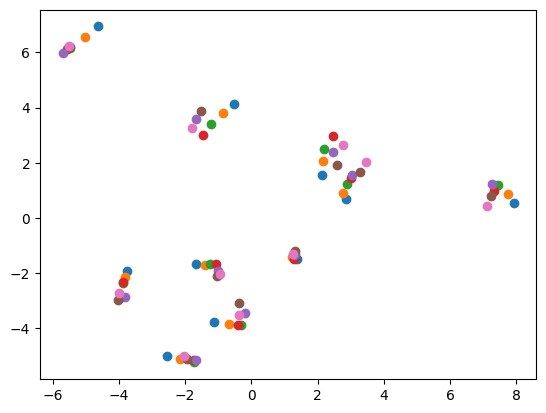

In [29]:
for i in range(len(x_s)):
    plt.scatter(x_s[i], y_s[i])
plt.show()

## Observe Gradient Norm During Training
* Record the gradient noorm and the loss during training
* Plot them on one figure

In [31]:
def get_gradient_norm(params):
    grad_all = 0.0
    for p in params:
        grad = 0.0
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy() ** 2).sum()
        grad_all += grad
    grad_norm = grad_all ** 0.5
    #print("grad_norm", grad_norm)
    return grad_norm

In [33]:
model1 = Model()

# Training loop
epochs = 1000

BATCH_SIZE = 32
#BATCH_SIZE = 128
LEARNING_RATE = 0.01

loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model1.parameters(), lr=LEARNING_RATE) #SGD


epoch_count = []
loss_values = []
accuracy_values = []
gradient_values = []

weights = []
for epoch in range(epochs):
    sample = np.random.randint(0, X_train.shape[0], size=(BATCH_SIZE))
    # sample from whole array
    X = X_train[sample]
    X = torch.tensor(X.reshape((-1, 28*28))).float()
    Y = torch.tensor(Y_train[sample])

    optimizer.zero_grad()

    y_prediction = model1(X)

    # Calculate accuracy
    max_pred = torch.argmax(y_prediction, dim=1) # max predicted value
    accuracy = (max_pred == Y).float().mean()# counts the number of correct predictions in model1 (num of True)
    accuracy_values.append(accuracy)

    loss = loss_function(y_prediction, Y)

    loss.backward()

    optimizer.step()
    epoch_count.append(epoch)
    loss_values.append(loss.item())
    
    # Calculate gradient
    parameters = model1.parameters()
    grad_norm = get_gradient_norm(parameters)
    gradient_values.append(grad_norm)

    if (epoch % 100 == 0):
        print(f"Epoch: {epoch} ,Loss: {loss.item()}, | Accuracy: {accuracy.item()}, | Gradient Norm: {grad_norm}")




Epoch: 0 ,Loss: 40.823204040527344, | Accuracy: 0.0, | Gradient Norm: 571.6489239780014
Epoch: 100 ,Loss: 2.1552329063415527, | Accuracy: 0.125, | Gradient Norm: 4.3046281997973015
Epoch: 200 ,Loss: 1.4749231338500977, | Accuracy: 0.4375, | Gradient Norm: 3.0891656855684757
Epoch: 300 ,Loss: 1.8988665342330933, | Accuracy: 0.3125, | Gradient Norm: 4.435646835845013
Epoch: 400 ,Loss: 2.2252113819122314, | Accuracy: 0.09375, | Gradient Norm: 0.14638293592408813
Epoch: 500 ,Loss: 2.0087180137634277, | Accuracy: 0.1875, | Gradient Norm: 0.14194860004616852
Epoch: 600 ,Loss: 2.1840226650238037, | Accuracy: 0.15625, | Gradient Norm: 4.0620050493845135
Epoch: 700 ,Loss: 2.52656888961792, | Accuracy: 0.375, | Gradient Norm: 18.35051585280058
Epoch: 800 ,Loss: 2.0862362384796143, | Accuracy: 0.125, | Gradient Norm: 0.226735205976406
Epoch: 900 ,Loss: 2.001368761062622, | Accuracy: 0.15625, | Gradient Norm: 0.25438592604975696


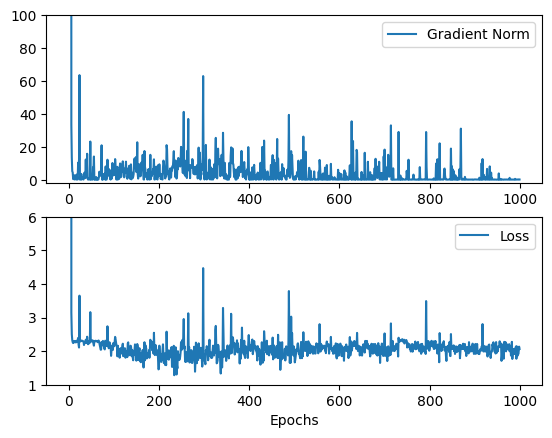

In [34]:
fig, axs = plt.subplots(2)
fig.suptitle("")
axs[0].plot(epoch_count, gradient_values, label="Gradient Norm")
axs[0].legend()
axs[0].set_ylim([-2, 100])
#axs[0].ylim(-0.1, 100)

axs[1].plot(epoch_count, loss_values, label="Loss")
axs[1].legend()
axs[1].set_ylim([1, 6])
#axs[1].ylim(-0.1, 5)
plt.legend()
plt.xlabel("Epochs")
plt.show()

## Reach Point where gradient norm is zero
* Change objective function to gradient norm and keep training

In [ ]:

# THIS IS THE SECOND LINK IN THE ANNOUNCEMENTS ON HOW TO CALCULATE THE HESSIAN
# THIS BREAKES PALMETTO !!!!!
# WHY?????????/
# Create Model
model = Model()

# Dataset 
BATCH_SIZE = 8
sample = np.random.randint(0, X_train.shape[0], size=(BATCH_SIZE))

X = X_train[sample]
X = torch.tensor(X.reshape((-1, 28*28))).float()
Y = torch.tensor(Y_train[sample])

# Define Loss function
def loss_gradient_norm(params):
    grad_all = 0.0
    for p in params:
        grad = 0.0
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy() ** 2).sum()
        grad_all += grad
    grad_norm = torch.tensor(grad_all ** 0.5)
    #print("grad_norm", grad_norm)
    loss = torch.mean((grad_norm)**2)
    return loss

# Calculate Hessian
#hessian_func = hessian(loss) <------------------ Too expensive to compute :(
#print("hessian_func", hessian_func)
#start = time.time()

#H = hessian_func(tuple(model.parameters()))
#print("H", H)

#H = torch.cat([torch.cat([e.flatten() for e in Hpart]) for Hpart in H]) # flatten
#H = H.reshape(num_param, num_param)

#print(time.time() - start)

In [ ]:
import torch
import numpy as np
import functools
import matplotlib.pyplot as plt


def LM(model,loss,n_iter=3):

    alpha=1e-3
    loss_hist=[]
    for i in range(n_iter):
        model.train()
        out=model(X).unsqueeze(1)
        loss_out=loss(out)
        prev_loss=loss_out.item()
        gradients=torch.autograd.grad(loss_out, model.parameters(), create_graph=True)

        model.eval()
        Hessian, g_vector=eval_hessian(gradients, model)

        dx=-1(alpha*torch.eye(Hessian.shape[-1]).cuda()+Hessian).inverse().mm(g_vector).detach()

        cnt=0
        model.zero_grad()

        for p in model.parameters():

            mm=torch.Tensor([p.shape]).tolist()[0]
            num=int(functools.reduce(lambda x,y:x*y,mm,1))
            p.requires_grad=False
            p+=dx[cnt:cnt+num,:].reshape(p.shape)
            cnt+=num
            p.requires_grad=True


        out=model(X).unsqueeze(1)
        loss_out=loss(out)

        if loss_out<prev_loss:
            print("Successful iteration")
            loss_hist.append(loss_out)
            alpha/=10
        else:
            print("Augmenting step size")
            alpha*=10
            cnt=0
            for p in model.parameters():

                mm=torch.Tensor([p.shape]).tolist()[0]
                num=int(functools.reduce(lambda x,y:x*y,mm,1))
                p.requires_grad=False
                p-=dx[cnt:cnt+num,:].reshape(p.shape)
                cnt+=num
                p.requires_grad=True

    return loss_hist 

def eval_hessian(loss_grad, model):
    cnt = 0
    for g in loss_grad:
        g_vector = g.contiguous().view(-1) if cnt == 0 else torch.cat([g_vector,     g.contiguous().view(-1)])
        cnt = 1
    l = g_vector.size(0)
    hessian = torch.zeros(l, l).cuda()
    for idx in range(l):
        grad2rd = torch.autograd.grad(g_vector[idx], model.parameters(), create_graph=True)
        cnt = 0
        for g in grad2rd:
            g2 = g.contiguous().view(-1) if cnt == 0 else torch.cat([g2, g.contiguous().view(-1)])
            cnt = 1
        hessian[idx] = g2
        
    return hessian, g_vector.unsqueeze(1)

def loss_gradient_norm(params):
    grad_all = 0.0
    for p in params:
        grad = 0.0
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy() ** 2).sum()
        grad_all += grad
    grad_norm = torch.tensor(grad_all ** 0.5)
    #print("grad_norm", grad_norm)
    loss = torch.mean((grad_norm)**2)
    return loss

list_loss = []
list_min_ratio = []
# Dataset 
BATCH_SIZE = 1
sample = np.random.randint(0, X_train.shape[0], size=(BATCH_SIZE))

X = X_train[sample].astype("float64")
#X = torch.tensor(X.reshape((-1, 28*28)), requires_grad=True).float()
X = torch.tensor(X.reshape((-1, 28*28))).float()

# Create Model
model = Model()
loss_hist = LM(model, lambda x:loss_gradient_norm(x))
print("loss_hist", loss_hist)



In [ ]:
from torch.autograd.functional import hessian
params = model1.parameters()
print("params", params)
for p in params:
    print("type(p)", type(p))
hessian = hessian(get_gradient_norm, params)
#print("hessian", hessian)

In [ ]:
plt.scatter(list_loss, list_min_ratio)
plt.show()